In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error 
import xgboost as xgb

# load data

In [2]:
df_train = pd.read_csv('train.csv', index_col=0)
df_test = pd.read_csv('test.csv')
df_items = pd.read_csv('items.csv')
df_item_categories = pd.read_csv('item_categories.csv')
df_shops = pd.read_csv('shops.csv')

In [3]:
print(df_train.shape, df_test.shape, df_items.shape, df_item_categories.shape, df_shops.shape)

(2935849, 7) (214200, 3) (22170, 2) (84, 1) (60, 1)


In [4]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


In [5]:
df_test.tail()

,ID,shop_id,item_id
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


# EDA

- 60 shops
- 84 categories
- 22170 items

In [6]:
# number of item in train set
df_train.item_id.nunique()

21807

In [7]:
# number of item in test set
df_test.item_id.nunique()

5100

In [8]:
# number of item only in the train set
len(set(df_train.item_id) - set(df_test.item_id))

17070

In [9]:
# number of item only in the test set
len(set(df_test.item_id) - set(df_train.item_id))

363

In [10]:
df_train.shop_id.nunique()

60

In [11]:
df_test.shop_id.nunique()

42

In [12]:
len(set(df_test.shop_id) - set(df_train.shop_id))

0

In [13]:
df_train.isnull().sum()

date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
dtype: int64

## checkout outliers, missing or wrong values

### Check outliers

In [14]:
# cehck descriptive statistics
df_train[['item_cnt_day', 'item_price']].describe()

,item_cnt_day,item_price
count,2.935849e+06,2.935849e+06
mean,1.242641e+00,8.908532e+02
std,2.618834e+00,1.729800e+03
min,-2.200000e+01,-1.000000e+00
25%,1.000000e+00,2.490000e+02
50%,1.000000e+00,3.990000e+02
75%,1.000000e+00,9.990000e+02
max,2.169000e+03,3.079800e+05


There are some item_cnt_day and item_price are negative values.

### check percentile and draw boxplot 

In [15]:
np.percentile(df_train['item_cnt_day'], [1, 99])

array([1., 5.])

In [16]:
np.percentile(df_train['item_price'], [1, 99])

array([5.000e+00, 5.999e+03])

<Axes: xlabel='item_cnt_day'>

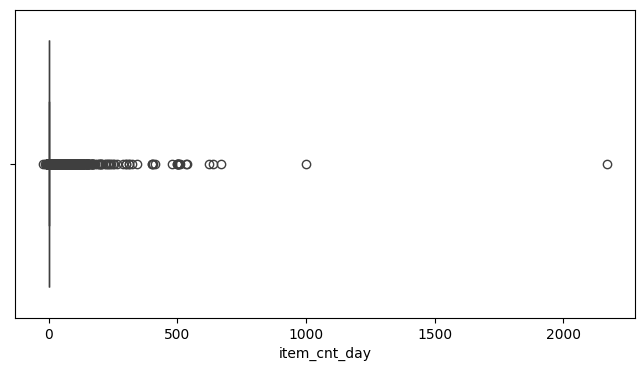

In [17]:
f, ax = plt.subplots(figsize=(8, 4))
# ax.set_xscale("log")
sns.boxplot(x=df_train['item_cnt_day'])

<Axes: xlabel='item_price'>

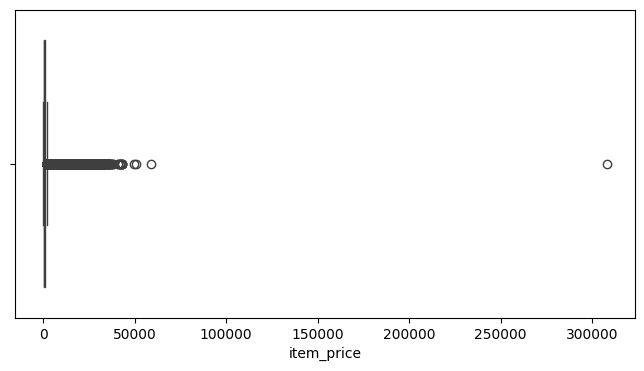

In [18]:
f, ax = plt.subplots(figsize=(8, 4))
# ax.set_xscale("log")
sns.boxplot(x=df_train['item_price'])

In [19]:
df_train_clean = df_train[(df_train.item_cnt_day < 500) & (df_train.item_cnt_day > 0)]

In [20]:
df_train_clean = df_train_clean[(df_train_clean.item_price < 50_000) & (df_train_clean.item_price > 0)]

In [21]:
df_train_clean.shape

(2928475, 7)

In [22]:
# total sale trend

In [23]:
df_train_clean.groupby('date_block_num')['item_cnt_day'].sum()

date_block_num
0     131850.0
1     128382.0
2     147438.0
3     107439.0
4     107147.0
5     125583.0
6     117165.0
7     125586.0
8     133550.0
9     127815.0
10    130270.0
11    183669.0
12    117243.0
13    109975.0
14    115500.0
15     96242.0
16     97938.0
17     97122.0
18     91505.0
19    102910.0
20     99427.0
21    106603.0
22    118050.0
23    168555.0
24    110299.0
25     84419.0
26     82233.0
27     77324.0
28     71896.0
29     64237.0
30     63316.0
31     66196.0
32     70646.0
33     68515.0
Name: item_cnt_day, dtype: float64

<Axes: xlabel='date_block_num'>

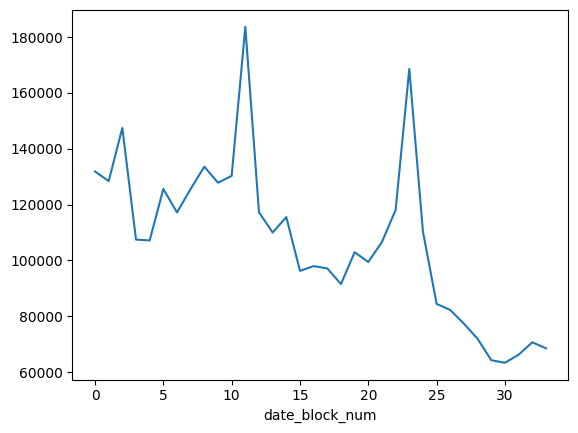

In [24]:
df_train_clean.groupby('date_block_num')['item_cnt_day'].sum().plot()

In [25]:
df_train_month = df_train_clean.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].sum().reset_index(name='item_cnt_month')

In [26]:
df_train_month[df_train_month.item_cnt_month < 50].item_cnt_month.describe()

count    1.605271e+06
mean     2.046582e+00
std      2.956833e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      4.900000e+01
Name: item_cnt_month, dtype: float64

<Axes: >

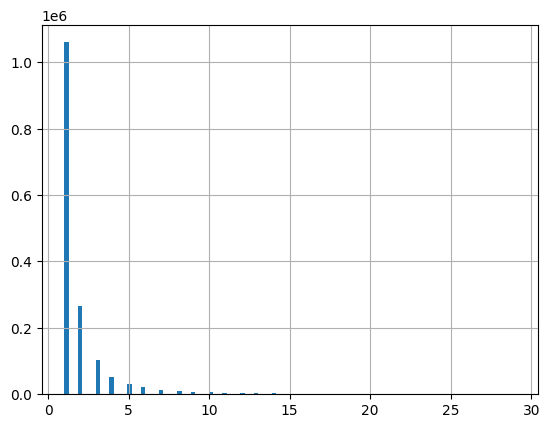

In [27]:
df_train_month[df_train_month.item_cnt_month < 30].item_cnt_month.hist(bins=100)

In [28]:
# check percentile of the item_cnt_month, 1% and 99%
np.percentile(df_train_month.item_cnt_month, [1, 99])

array([ 1., 17.])

In [29]:
# for these percentile, we can clip the item_cnt_month from 0 to 20

In [30]:
df_pivot = df_train_clean.pivot_table(index=['shop_id','item_id'], 
                                      columns='date_block_num', 
                                      values='item_cnt_day',
                                      aggfunc='sum').fillna(0).clip(0,20).reset_index()
df_pivot.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,30,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,6.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
df_pivot.shape

(424095, 36)

In [32]:
# cast type of item and category columns to string, it will help the model to learn as categorical variable
df_items['item_id'] = df_items['item_id'].astype('str')
df_items['item_category_id'] = df_items['item_category_id'].astype('str')

df_pivot['shop_id']= df_pivot.shop_id.astype('str')
df_pivot['item_id']= df_pivot.item_id.astype('str')
## join
df_pivot = df_pivot.merge(df_items, how="left", on="item_id")

In [33]:
# check null values
df_pivot.item_category_id.isna().sum()

0

In [34]:
df_data_train = df_pivot[['shop_id', 'item_id', 'item_category_id'] + list(range(34))]
df_data_train.head()

,shop_id,item_id,item_category_id,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,30,40,0.0,20.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,0.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,6.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,3.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,1.0,14.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
print(df_data_train.dtypes)

shop_id              object
item_id              object
item_category_id     object
0                   float64
1                   float64
2                   float64
3                   float64
4                   float64
5                   float64
6                   float64
7                   float64
8                   float64
9                   float64
10                  float64
11                  float64
12                  float64
13                  float64
14                  float64
15                  float64
16                  float64
17                  float64
18                  float64
19                  float64
20                  float64
21                  float64
22                  float64
23                  float64
24                  float64
25                  float64
26                  float64
27                  float64
28                  float64
29                  float64
30                  float64
31                  float64
32                  

# Define model and train

## Approach
- We use XGB for predict the amount of products sold in shops in next month. 
- We will feed the entire 32 months of sales data into the model. We expect that the model can use this data to learn the patterns of sales and seasonality.
- `shop_id`, `item_id`, and `item_category_id` are cast to string and trained as categorical values.
- We use `date_block_num=33` as the label to train.

In [36]:

param = {'max_depth':10, 
         'n_estimators':1000, 
         'subsample':0.8,
         'min_child_weight':0.5,
         'eta':0.3, 
         'seed':123,
         'eval_metric':'rmse'}

In [37]:
feature_names = list(df_data_train.columns)[:-1]
feature_names = [str(e) for e in feature_names]

In [38]:
progress = dict()
xgbtrain = xgb.DMatrix(df_data_train.iloc[:, (df_data_train.columns != 33)].values, 
                       df_data_train.iloc[:, df_data_train.columns == 33].values)


In [39]:
bst = xgb.train(param, xgbtrain)
preds = bst.predict(xgb.DMatrix(df_data_train.iloc[:, (df_data_train.columns != 33)].values))

rmse = np.sqrt(mean_squared_error(preds, df_data_train.iloc[:, df_data_train.columns == 33].values))
print(rmse)

/Users/duc/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:21:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


0.6021909097420388


In [40]:
bst.feature_names= feature_names

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

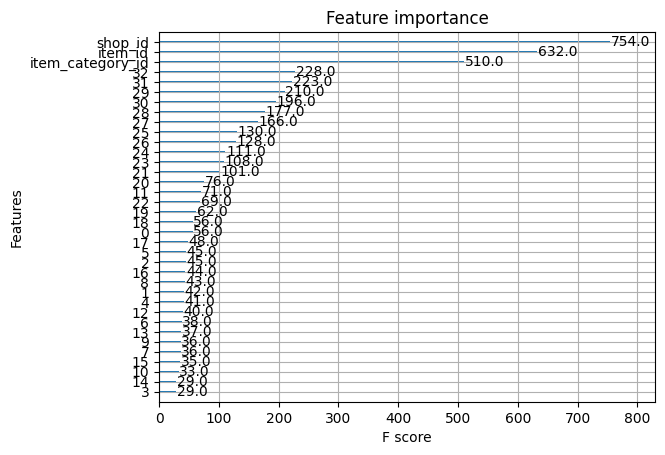

In [41]:
xgb.plot_importance(bst)

In [42]:
bst.feature_names = None

In [43]:
df_result = df_test.copy(deep=True)
df_result['shop_id']= df_result.shop_id.astype('str')
df_result['item_id']= df_result.item_id.astype('str')

df_result = df_result.merge(df_data_train, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
df_result.head()


,ID,shop_id,item_id,item_category_id,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,19,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,19,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,23,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# shift the columns 1 month to predict the next month
new_cols = [e for e in df_result.columns if type(e) != int] + [e-1 for e in df_result.columns if type(e) == int]

In [45]:
df_result.columns = new_cols

In [46]:
# drop the first month (month -1)
df_result.drop(columns=[-1], inplace=True)

In [47]:
pred_results = bst.predict(xgb.DMatrix(df_result.iloc[:, (df_result.columns != 'ID')].values))

In [48]:
df_output = df_result[['ID', 'shop_id', 'item_id']]
df_output['item_cnt_month'] = pred_results
df_output.item_cnt_month = df_output.item_cnt_month.round().clip(0,20).astype(int)
# export result
df_output.to_csv('submission.csv', index=False)

/var/folders/s6/l5_2mz3s0jnf_yzxk8_9qln80000gn/T/ipykernel_24867/566785911.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output['item_cnt_month'] = pred_results
/var/folders/s6/l5_2mz3s0jnf_yzxk8_9qln80000gn/T/ipykernel_24867/566785911.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output.item_cnt_month = df_output.item_cnt_month.round().clip(0,20).astype(int)


In [49]:
# visualize the trend of prediction

In [50]:
df_result['pred_item_cnt_month'] = pred_results

<Axes: >

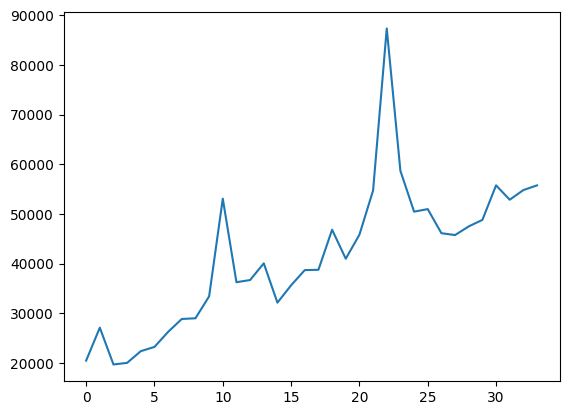

In [51]:
df_result.iloc[:,4:].astype(float).sum().plot()

In [52]:
df_result[df_result.pred_item_cnt_month > 5]

,ID,shop_id,item_id,item_category_id,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,pred_item_cnt_month
58,58,5,3350,19,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,8.0,6.326072
59,59,5,3351,20,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,4.0,8.990004
118,118,5,9355,70,0.0,0.0,0.0,0.0,0.0,0.0,...,17.0,18.0,10.0,12.0,11.0,14.0,18.0,16.0,8.0,10.185968
274,274,5,17717,79,0.0,5.0,0.0,1.0,0.0,0.0,...,19.0,13.0,13.0,8.0,5.0,8.0,19.0,19.0,12.0,6.616676
347,347,5,14229,30,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,3.0,3.0,3.0,1.0,3.0,4.0,7.0,6.013197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205490,205490,39,17270,37,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,10.620619
209233,209233,45,10201,28,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,7.200278
209252,209252,45,10202,20,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,7.108754
209374,209374,45,17717,79,8.0,5.0,7.0,1.0,3.0,6.0,...,6.0,17.0,5.0,1.0,4.0,7.0,5.0,0.0,6.0,6.105186


## output distribution check

<Axes: >

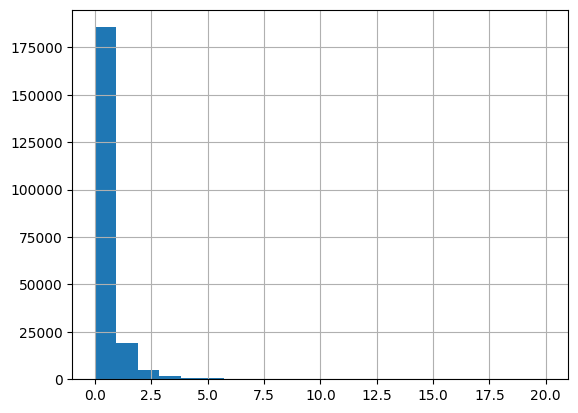

In [54]:
df_result[32].hist(bins=21)

<Axes: >

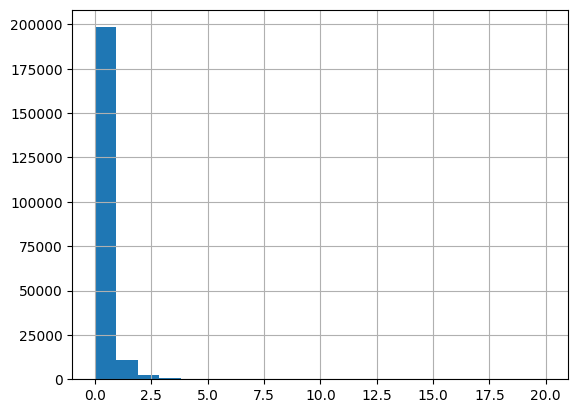

In [56]:
df_result['pred_item_cnt_month'].round().clip(0,20).hist(bins=21)